# readme

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GroupKFold, KFold, RepeatedKFold,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_validate, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

warnings.filterwarnings('ignore')

In [2]:
def show_tree(tree, X_train):
    export_graphviz(tree,
                    out_file='tree.dot',
                    feature_names=X_train.columns,
                    class_names=['0', '1'],
                    filled=True,
                    rounded=True)

    g = pydotplus.graph_from_dot_file(path='tree.dot')
    display(Image(g.create_png()))

In [3]:
train = pd.read_csv('../input/train.csv', usecols=['Survived', 'Sex', 'Pclass'])
test = pd.read_csv('../input/test.csv', usecols=['Sex', 'Pclass'])
submit_data = pd.read_csv('../input/gender_submission.csv')

# Data Preparation

In [4]:
# pd.Series.map() に dict を渡すと置換してくれる(頻出)
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0})
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})

In [5]:
X = train[['Pclass', 'Sex']]
y = train['Survived']

X_test = test.copy() # 命名規則を守るため

## Training

In [6]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0)

clf.fit(X, y)
train_acc = clf.score(X, y)

print(f'Training accuracy: {train_acc:.5f}')

Training accuracy: 0.78676


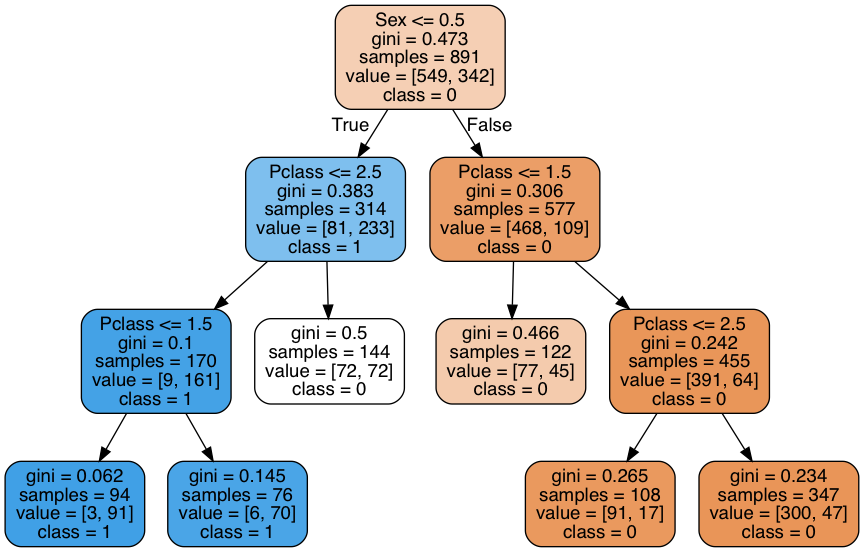

In [7]:
show_tree(clf, X)

## Making Submissoin Data

In [8]:
submit_data['Survived'] = clf.predict(X_test)
submit_data.to_csv('dct01.csv', index=False) # 0.78892 -> 0.75598

# Cross-Validation
>交差検証は新しいデータに適用するためのモデルを作る方法ではないということに注意しておこう。交差検証はモデルを返さない。
>
> cross_val_scoreを呼び出すと内部的には複数のモデルが構築されるが、交差検証の目的は、与えられたアルゴリズムが特定のデータセットに対してどの程度汎化できるかを評価することだけにある。
>
> 『Pythonではじめる機械学習 ―scikit-learnで学ぶ特徴量エンジニアリングと機械学習の基礎』


## KFold

In [9]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

valid_acc_list = []

for train_index, valid_index in kf.split(X, y):
    X_train = X.iloc[train_index]
    X_valid = X.iloc[valid_index]

    y_train = y[train_index]  # こっちはDataFrameじゃなくてSeriesなのでアクセス方法が違う
    y_valid = y[valid_index]

    clf = DecisionTreeClassifier(max_depth=3, random_state=0)

    clf.fit(X_train, y_train)

    valid_acc = clf.score(X_valid, y_valid)
    valid_acc_list.append(valid_acc)

valid_acc_list

[0.7877094972067039,
 0.7640449438202247,
 0.7921348314606742,
 0.7808988764044944,
 0.7191011235955056]

In [10]:
print(f'Mean valid acc: {np.mean(valid_acc_list):.3f}')
print(f'Valid acc std: {np.std(valid_acc_list):.3f}')

Mean valid acc: 0.769
Valid acc std: 0.027


## StratifiedKFold

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=0)

valid_acc_list = []

for train_index, valid_index in skf.split(X, y):
    X_train = X.iloc[train_index]
    X_valid = X.iloc[valid_index]

    y_train = y[train_index]  # こっちはDataFrameじゃなくてSeriesなのでアクセス方法が違う
    y_valid = y[valid_index]

    clf = DecisionTreeClassifier(max_depth=3, random_state=0)

    clf.fit(X_train, y_train)

    valid_acc = clf.score(X_valid, y_valid)
    valid_acc_list.append(valid_acc)
    
valid_acc_list

[0.7486033519553073,
 0.7932960893854749,
 0.7865168539325843,
 0.7528089887640449,
 0.7853107344632768]

In [12]:
print(f'Mean valid acc: {np.mean(valid_acc_list):.3f}')
print(f'Valid acc std: {np.std(valid_acc_list):.3f}')

Mean valid acc: 0.773
Valid acc std: 0.019


## sklearn.model_selection.cross_validate()
- We can use Parallel processing
    - arugment: 'n_jobs'

### KFold

In [13]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)

clf = DecisionTreeClassifier(max_depth=3, random_state=0)
cv_result = cross_validate(clf, X, y, scoring=['accuracy'], cv=kf)

cv_result

{'fit_time': array([0.00186086, 0.00149417, 0.00143003, 0.0013361 , 0.00132918]),
 'score_time': array([0.00080299, 0.00070596, 0.00069785, 0.00067616, 0.00072289]),
 'test_accuracy': array([0.7877095 , 0.76404494, 0.79213483, 0.78089888, 0.71910112])}

In [14]:
print(f'Mean valid acc: {np.mean(cv_result["test_accuracy"]):.3f}')
print(f'Valid acc std: {np.std(cv_result["test_accuracy"]):.3f}')

Mean valid acc: 0.769
Valid acc std: 0.027


### skf

In [15]:
skf = StratifiedKFold(n_splits=5, random_state=0)

clf = DecisionTreeClassifier(max_depth=3, random_state=0)

cv_result = cross_validate(clf, X, y, scoring=['accuracy'], cv=skf)

cv_result

{'fit_time': array([0.00169992, 0.00127697, 0.00177312, 0.00140309, 0.00144196]),
 'score_time': array([0.00069499, 0.00069404, 0.0007298 , 0.00069499, 0.0008347 ]),
 'test_accuracy': array([0.74860335, 0.79329609, 0.78651685, 0.75280899, 0.78531073])}

In [16]:
print(f'Mean valid acc: {np.mean(cv_result["test_accuracy"]):.3f}')
print(f'Valid acc std: {np.std(cv_result["test_accuracy"]):.3f}')

Mean valid acc: 0.773
Valid acc std: 0.019


### default

In [17]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
cv_result = cross_validate(clf, X, y, scoring=['accuracy'])

cv_result

{'fit_time': array([0.00221324, 0.00198889, 0.0015409 ]),
 'score_time': array([0.00100374, 0.00083184, 0.00086117]),
 'test_accuracy': array([0.75757576, 0.8013468 , 0.77104377])}

In [18]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0)
cv_result = cross_validate(clf, X, y, scoring=['accuracy'], cv=5)

cv_result

{'fit_time': array([0.00163293, 0.00138116, 0.00127006, 0.00122595, 0.00152683]),
 'score_time': array([0.00071716, 0.00074482, 0.00065303, 0.00065875, 0.00074887]),
 'test_accuracy': array([0.74860335, 0.79329609, 0.78651685, 0.75280899, 0.78531073])}

## Model Comparison

In [19]:
clf = LogisticRegression(random_state=0)
cv_result = cross_validate(clf, X, y, scoring=['accuracy'], cv=5)

cv_result

{'fit_time': array([0.00221181, 0.00177288, 0.00195622, 0.00209904, 0.00228286]),
 'score_time': array([0.00073099, 0.00065422, 0.000664  , 0.00127292, 0.0007782 ]),
 'test_accuracy': array([0.80446927, 0.80446927, 0.78651685, 0.75280899, 0.78531073])}

In [20]:
clf = KNeighborsClassifier()
cv_result = cross_validate(clf, X, y, scoring=['accuracy'], cv=5)

cv_result

{'fit_time': array([0.00208426, 0.00153399, 0.00149512, 0.00152802, 0.00142193]),
 'score_time': array([0.00689197, 0.0061152 , 0.00548506, 0.00457191, 0.00443983]),
 'test_accuracy': array([0.80446927, 0.72625698, 0.78651685, 0.78089888, 0.78531073])}

In [21]:
clf = SVC(random_state=0)
cv_result = cross_validate(clf, X, y, scoring=['accuracy'], cv=5)

cv_result

{'fit_time': array([0.00587225, 0.00571895, 0.0059309 , 0.00547886, 0.00571895]),
 'score_time': array([0.00154805, 0.0018661 , 0.00157285, 0.00194716, 0.00144792]),
 'test_accuracy': array([0.74860335, 0.79329609, 0.78651685, 0.75280899, 0.78531073])}